# TP3

In [2]:
import cv2
import numpy as np
from matplotlib import pyplot as plt 

### Encontrar el logotipo de la gaseosa dentro de las imágenes provistas en Material_TPs/TP3/images a partir del template Material_TPs/TP3/template

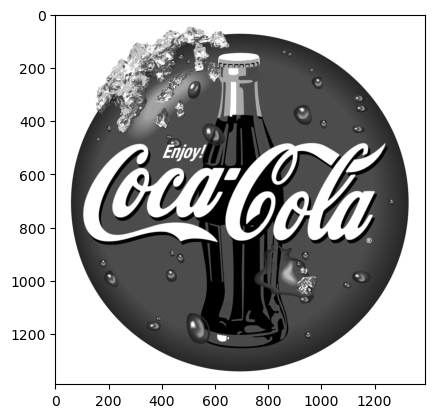

In [14]:
template_image = cv2.imread('TP3/template/pattern.png', cv2.IMREAD_GRAYSCALE)
w, h = template_image.shape[::-1]

image_1 =  cv2.imread('TP3/images/COCA-COLA-LOGO.jpg', cv2.IMREAD_GRAYSCALE)
image_2 =  cv2.imread('TP3/images/coca_logo_1.png', cv2.IMREAD_GRAYSCALE)
image_3 =  cv2.imread('TP3/images/coca_logo_2.png', cv2.IMREAD_GRAYSCALE)
image_4 =  cv2.imread('TP3/images/coca_multi.png', cv2.IMREAD_GRAYSCALE)
image_5 =  cv2.imread('TP3/images/coca_retro_1.png', cv2.IMREAD_GRAYSCALE)
image_6 =  cv2.imread('TP3/images/coca_retro_2.png', cv2.IMREAD_GRAYSCALE)
image_7 =  cv2.imread('TP3/images/logo_1.png', cv2.IMREAD_GRAYSCALE)

plt.imshow(255-template_image, cmap='gray')
plt.imshow(image_1, cmap='gray')


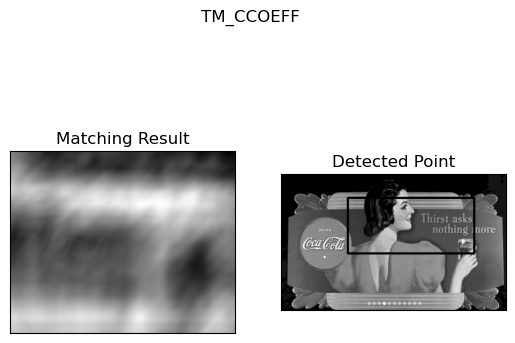

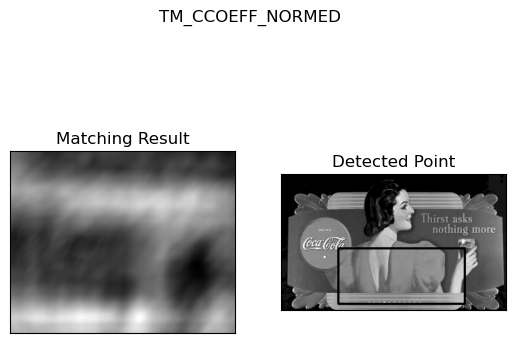

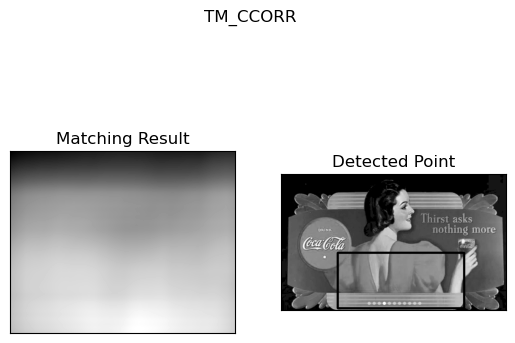

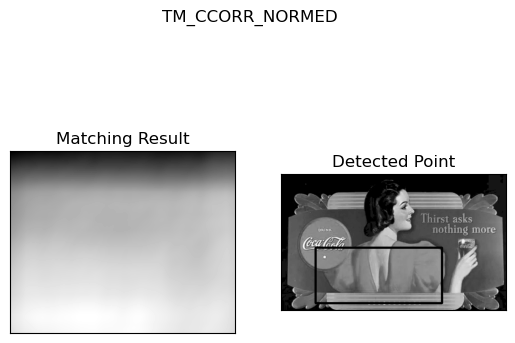

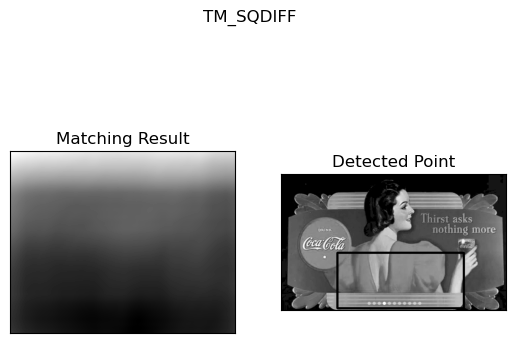

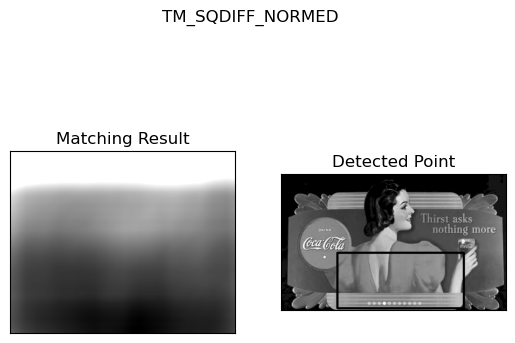

In [12]:
# All the 6 methods for comparison in a list
methods = ['TM_CCOEFF', 'TM_CCOEFF_NORMED', 'TM_CCORR',
            'TM_CCORR_NORMED', 'TM_SQDIFF', 'TM_SQDIFF_NORMED']
 
for meth in methods:
    img = image_6.copy()
    method = getattr(cv2, meth)
 
    # Apply template Matching
    res = cv2.matchTemplate(img,template_image,method)
    min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(res)
 
    # If the method is TM_SQDIFF or TM_SQDIFF_NORMED, take minimum
    if method in [cv2.TM_SQDIFF, cv2.TM_SQDIFF_NORMED]:
        top_left = min_loc
    else:
        top_left = max_loc
    bottom_right = (top_left[0] + w, top_left[1] + h)
 
    cv2.rectangle(img,top_left, bottom_right, 0, 6)
 
    plt.subplot(121),plt.imshow(res,cmap = 'gray')
    plt.title('Matching Result'), plt.xticks([]), plt.yticks([])
    plt.subplot(122),plt.imshow(img,cmap = 'gray')
    plt.title('Detected Point'), plt.xticks([]), plt.yticks([])
    plt.suptitle(meth)
 
    plt.show()

In [7]:
 # Crear el detector ORB
orb = cv2.ORB_create()

# Detectar y computar características clave y descriptores
keypoints_logo, descriptors_logo = orb.detectAndCompute(template_image, None)
keypoints_image, descriptors_image = orb.detectAndCompute(image_2, None)

In [8]:
# Usar el matcher BruteForce-Hamming (adecuado para ORB)
bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)

# Encontrar las coincidencias
matches = bf.match(descriptors_logo, descriptors_image)

# Ordenar las coincidencias por distancia
matches = sorted(matches, key=lambda x: x.distance)

# Dibujar las mejores coincidencias
result = cv2.drawMatches(template_image, keypoints_logo, image_2, keypoints_image, matches[:20], None, flags=2)

# Mostrar el resultado
cv2.imshow("Coincidencias", result)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [9]:
# Extraer los puntos clave correspondientes
src_pts = np.float32([keypoints_logo[m.queryIdx].pt for m in matches]).reshape(-1, 1, 2)
dst_pts = np.float32([keypoints_image[m.trainIdx].pt for m in matches]).reshape(-1, 1, 2)

# Calcular la homografía
M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)

# Obtener las dimensiones del logo
h, w = template_image.shape

# Definir las esquinas del logo
pts = np.float32([[0, 0], [0, h - 1], [w - 1, h - 1], [w - 1, 0]]).reshape(-1, 1, 2)

# Transformar las esquinas según la homografía
dst = cv2.perspectiveTransform(pts, M)

# Dibujar las esquinas del logo detectado en la imagen
image = cv2.polylines(image_2, [np.int32(dst)], True, 255, 3, cv2.LINE_AA)

# Mostrar el resultado final
cv2.imshow("Logo detectado", image)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [14]:

# Convertir a escala de grises (opcional, pero suele mejorar el rendimiento)
gray_image = image_5.copy()
gray_template = template_image.copy()

# Obtener dimensiones del template
template_height, template_width = gray_template.shape[:2]

# Variables para guardar los mejores resultados
best_match = None
best_value = -1  # Inicializar con un valor bajo para comparar
best_scale = 1
best_position = (0, 0)

# Probar diferentes escalas de la imagen
for scale in np.linspace(0.5, 1.5, 20):  # Escalar de 50% a 150%
    resized_template = cv2.resize(gray_template, (int(template_width * scale), int(template_height * scale)))

    # Evitar que el template sea más grande que la imagen
    if resized_template.shape[0] > gray_image.shape[0] or resized_template.shape[1] > gray_image.shape[1]:
        continue

    # Aplicar el template matching
    result = cv2.matchTemplate(gray_image, resized_template, cv2.TM_CCOEFF_NORMED)

    # Obtener el valor máximo de coincidencia y su ubicación
    min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(result)

    # Guardar la mejor coincidencia
    if max_val > best_value:
        best_value = max_val
        best_match = resized_template
        best_position = max_loc
        best_scale = scale

# Dibujar un rectángulo alrededor del logo detectado
top_left = best_position
bottom_right = (top_left[0] + int(template_width * best_scale), top_left[1] + int(template_height * best_scale))
cv2.rectangle(image, top_left, bottom_right, (0, 255, 0), 2)

# Mostrar el resultado
cv2.imshow('Logo detectado', image)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [22]:
image_1_down = cv2.pyrDown(image_1)
image_1_2down = cv2.pyrDown(image_1_down)
image_1_up = cv2.pyrUp(image_1)
image_1_2up = cv2.pyrUp(image_1_up)
cv2.imshow('Logo detectado', image_1_up)
cv2.waitKey(0)
cv2.destroyAllWindows()